In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Usual Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

# Librosa (the mother of audio files)
import librosa
import librosa.display
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')

## Initial Audio Analysis

In [3]:
#loading audio file
y, sr = librosa.load('/content/drive/MyDrive/genres_original/blues/blues.00000.wav')

print('\nNumerical Features :', y)
print('\n shape of the converted Audio files :', np.shape(y))
print('\n Sample Rate (Hz):', sr)

print('Length of the Audio File in seconds:', len(y)/sr)


Numerical Features : [ 0.00732422  0.01660156  0.00762939 ... -0.05560303 -0.06106567
 -0.06417847]

 shape of the converted Audio files : (661794,)

 Sample Rate (Hz): 22050
Length of the Audio File in seconds: 30.013333333333332


In [4]:
#Trimming silence
audio_file, _ = librosa.effects.trim(y)

print('Audio File:', audio_file, '\n')
print('Audio File shape:', np.shape(audio_file))

Audio File: [ 0.00732422  0.01660156  0.00762939 ... -0.05560303 -0.06106567
 -0.06417847] 

Audio File shape: (661794,)


## Visual representation of Audio File

In [5]:
filelocation='/content/drive/MyDrive/genres_original'
hop_length=512
genre_names = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]


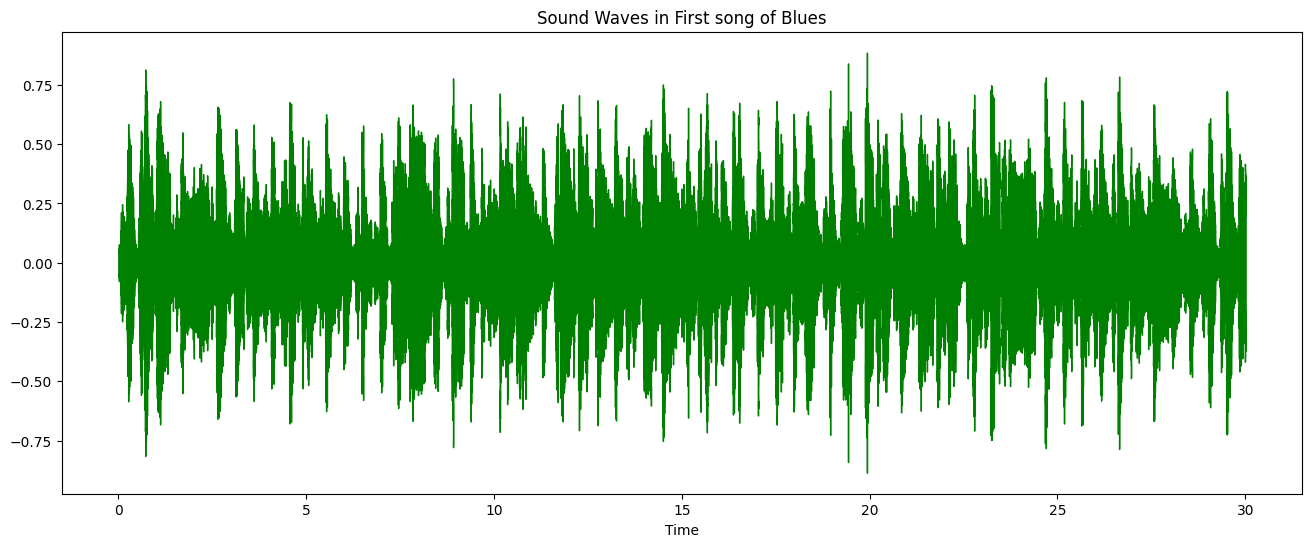

In [6]:
plt.figure(figsize = (16, 6))
librosa.display.waveshow(y = audio_file, sr = sr, color = "green");
plt.title("Sound Waves in First song of Blues");

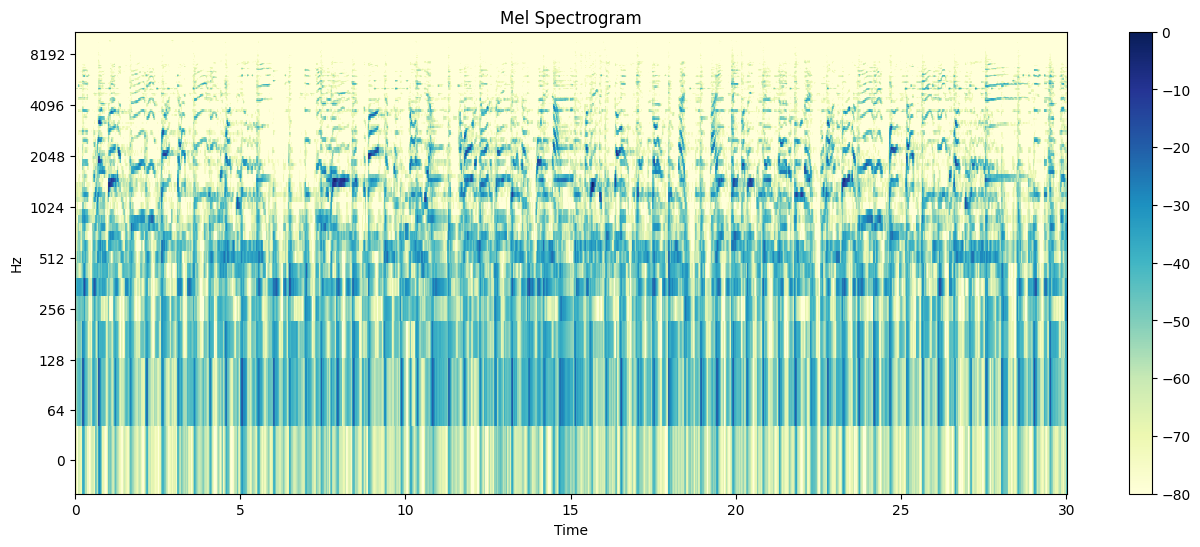

In [7]:
#Mel spectogram
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize=(16, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length=512, x_axis='time', y_axis='log',cmap='YlGnBu')
plt.colorbar()
plt.title("Mel Spectrogram",)
plt.show()


## Harmonic and precussive components

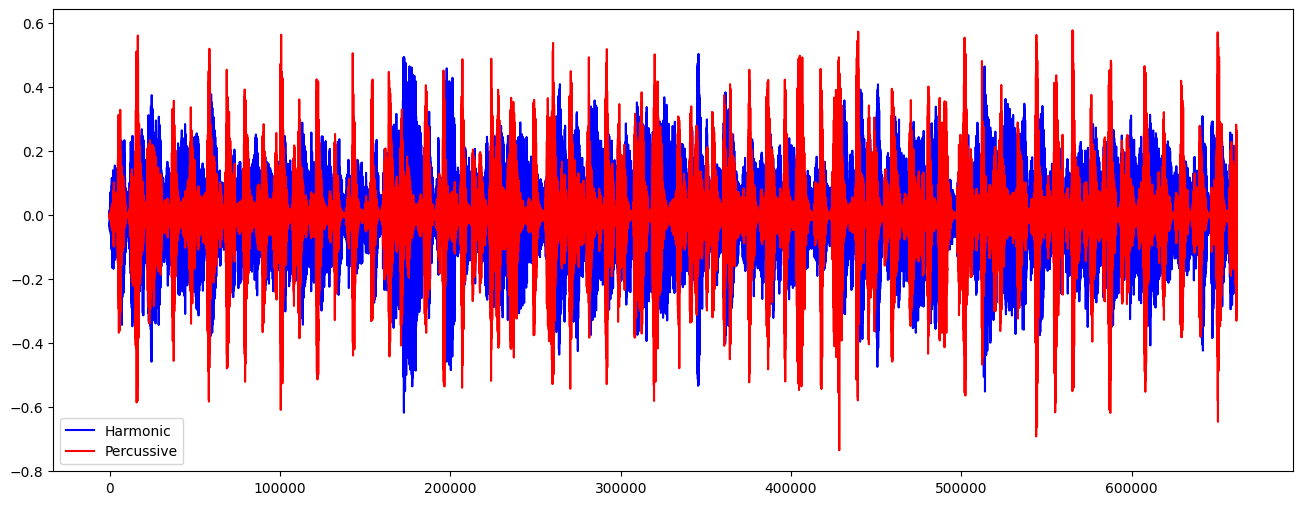

In [8]:
harm,perc = librosa.effects.hpss(audio_file)
plt.figure(figsize = (16, 6))
plt.plot(harm, color='blue',label='Harmonic');
plt.plot(perc, color='red',label='Percussive')
plt.legend()
plt.show()

In [9]:
#Tempo analysis
tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
print('Beats per Minute is ',tempo)


Beats per Minute is  123.046875


## Feature Engineering

In [10]:
#Extracting MFCCs
mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=512, n_mfcc=13)
mfcc.shape
mfcc.T[0:1200,:].shape

(1200, 13)

In [11]:
mfcc

array([[-2.40635422e+02, -2.11214355e+02, -1.93908890e+02, ...,
        -1.09999146e+02, -8.68144302e+01, -8.40735855e+01],
       [ 9.96476364e+01,  1.01042831e+02,  1.02243965e+02, ...,
         1.50079346e+02,  1.38948669e+02,  1.38309769e+02],
       [-7.40327501e+00, -8.35852528e+00,  1.91543472e+00, ...,
        -5.07951355e+01, -3.65361443e+01, -2.81363564e+01],
       ...,
       [-2.22809958e+00, -4.09619999e+00, -9.18501282e+00, ...,
        -1.21473036e+01, -9.28038597e+00, -1.04724808e+01],
       [-3.98046923e+00,  1.07179761e+00, -2.12721896e+00, ...,
         6.25275517e+00,  2.70401812e+00,  4.79288101e-02],
       [-9.62531447e-01, -1.38649821e+00, -3.84490538e+00, ...,
         4.95667553e+00, -2.70487618e+00, -6.35826874e+00]], dtype=float32)

In [12]:
spectral_center = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=512)
spectral_center.shape

(1, 1293)

In [13]:
chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=512)
chroma.shape

(12, 1293)

In [14]:
spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=512)
spectral_contrast.shape

(7, 1293)

## Batch processing of audio files for feature extraction

In [15]:
data=np.zeros((50, 128, 33), dtype=np.float64)
data.shape

(50, 128, 33)

In [16]:
x=librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
x.shape

(128, 1293)

In [17]:
q=librosa.feature.melspectrogram(y=y, sr=sr)
q.shape

(128, 1293)

In [19]:
genres_dir = "/content/drive/MyDrive/genres_original"
data = np.zeros((999,1200,33), dtype=np.float64)
target=[]
# List of genre names
genre_names = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
i=0
for genre in genre_names:
    genre_path = os.path.join(genres_dir, genre)

    # Loop through each file in the genre folder
    for filename in os.listdir(genre_path):
        file_path = os.path.join(genre_path, filename)
        y, sr = librosa.load(file_path)
        y, _ = librosa.effects.trim(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=512, n_mfcc=13)
        spectral_center = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=512)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=512)
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=512)
        target.append(genre)
        data[i, :, 0:13] = mfcc.T[0:1200,:]
        data[i, :, 13:14] = spectral_center.T[0:1200, :]
        data[i, :, 14:26] = chroma.T[0:1200, :]
        data[i, :, 26:33] = spectral_contrast.T[0:1200, :]
        print("Numerical features extracted from audio file %i of %i." % (i + 1, 999))
        i+=1

Numerical features extracted from audio file 1 of 999.
Numerical features extracted from audio file 2 of 999.
Numerical features extracted from audio file 3 of 999.
Numerical features extracted from audio file 4 of 999.
Numerical features extracted from audio file 5 of 999.
Numerical features extracted from audio file 6 of 999.
Numerical features extracted from audio file 7 of 999.
Numerical features extracted from audio file 8 of 999.
Numerical features extracted from audio file 9 of 999.
Numerical features extracted from audio file 10 of 999.
Numerical features extracted from audio file 11 of 999.
Numerical features extracted from audio file 12 of 999.
Numerical features extracted from audio file 13 of 999.
Numerical features extracted from audio file 14 of 999.
Numerical features extracted from audio file 15 of 999.
Numerical features extracted from audio file 16 of 999.
Numerical features extracted from audio file 17 of 999.
Numerical features extracted from audio file 18 of 999.
N

In [20]:
y=np.zeros((999,10))
for i,genre in enumerate(target):
  ind=genre_names.index(genre)
  y[i,ind]=1

In [21]:
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Reshape, Dropout
from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential()

# Add Convolutional layers
model.add(Conv1D(filters=712, kernel_size=3, activation='relu', input_shape=(1200, 33)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Flatten the output for LSTM
#model.add(Flatten())

# Reshape for LSTM input
#model.add(Reshape((32, 120)))  # Reshape to (timesteps, features)

# Add LSTM layers
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2))

# Add Dropout for regularization
model.add(Dropout(0.5))

# Output layer
model.add(Dense(units=10, activation='softmax'))

# Compile the model with a lower learning rate
opt = Adam()
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1198, 712)         71200     
                                                                 
 max_pooling1d (MaxPooling1  (None, 599, 712)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 597, 256)          547072    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 298, 256)          0         
 g1D)                                                            
                                                                 
 lstm (LSTM)                 (None, 298, 128)          197120    
                                                                 
 lstm_1 (LSTM)               (None, 32)                2

In [24]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.25, random_state=42)

In [25]:
batch_size = 35  # num of training examples per minibatch
num_epochs = 400
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=num_epochs,
)

Epoch 1/400
22/22 [==============================] - 50s 2s/step - loss: 2.3737 - accuracy: 0.0988
Epoch 2/400
22/22 [==============================] - 45s 2s/step - loss: 2.3347 - accuracy: 0.0908
Epoch 3/400
22/22 [==============================] - 44s 2s/step - loss: 2.3259 - accuracy: 0.1055
Epoch 4/400
22/22 [==============================] - 46s 2s/step - loss: 2.3173 - accuracy: 0.0935
Epoch 5/400
22/22 [==============================] - 48s 2s/step - loss: 2.3113 - accuracy: 0.1081
Epoch 6/400
22/22 [==============================] - 45s 2s/step - loss: 2.2978 - accuracy: 0.1495
Epoch 7/400
22/22 [==============================] - 45s 2s/step - loss: 2.2919 - accuracy: 0.1335
Epoch 8/400
22/22 [==============================] - 46s 2s/step - loss: 2.2869 - accuracy: 0.1202
Epoch 9/400
22/22 [==============================] - 47s 2s/step - loss: 2.2596 - accuracy: 0.1415
Epoch 10/400
22/22 [==============================] - 46s 2s/step - loss: 2.2258 - accuracy: 0.1789
Epoch 11/

In [26]:
score, accuracy = model.evaluate(
    x_test, y_test, batch_size=batch_size, verbose=1
)

8/8 [==============================] - 5s 479ms/step - loss: 1.3979 - accuracy: 0.4680
